### Grading Feedback
96%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [20]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [21]:
from pyspark.sql import functions as fn
from pyspark.sql import SparkSession
from pyspark.sql import Row

from pyspark.ml import feature
from pyspark.ml import Pipeline
from pyspark.ml import regression
from pyspark.ml import classification
from math import exp,fabs
from pyspark.ml.feature import StandardScaler
import re 
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType,DoubleType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Question 1
Using the get_training_filename function defined in the cell above, read the sms_spam.csv file into a spark dataframe named spam_df.  There should be no empty columns in spam_df.

In [22]:
# Your code here
spam_df = get_training_filename('sms_spam.csv')
spam_df = spark.read.csv(spam_df, header=True, inferSchema=True, mode="DROPMALFORMED")
spam_df.printSchema()
spam_df.show(5)

print(f"No of rows and columns in spam_df:({spam_df.count()},{len(spam_df.columns)})")
spam_df.toPandas().head(5)

root
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)

+----+--------------------+
|type|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows

No of rows and columns in spam_df:(5574,2)


,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Grading Feedback

# Question 2
Starting with spam_df, create a new dataframe named spam_df1.  Rename the spam_df type column to be named spam.  In the spam column, replace the string `spam` the with the integer 1 and the string `ham` with the integer 0.  Print the head and shape of spam_df1.

In [23]:
# your code here
spam_df1 = spam_df
spam_df1 = spam_df1.withColumnRenamed("type","spam")
spam_df1.show(4)

+----+--------------------+
|spam|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
+----+--------------------+
only showing top 4 rows



In [24]:
spam_df1 = spam_df1.withColumn('spam',regexp_replace('spam', 'ham', '0'))

In [25]:
spam_df1 = spam_df1.withColumn('spam', regexp_replace('spam', 'spam', '1'))

spam_df1 = spam_df1.withColumn("spam",col("spam").cast(IntegerType()))
spam_df1.printSchema()
spam_df1.toPandas().head(5)

root
 |-- spam: integer (nullable = true)
 |-- text: string (nullable = true)



,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Question 3
Starting with spam_df1, create a new dataframe named spam_df2 with a new column named filtered_text by removing stop words from the text column in spam_df.  Print the head and shape of spam_df2.

In [26]:
# your code here
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.utils import *
from pyspark.ml.feature import *
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover


spam_df_stop=spam_df1
def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, "^rt ", "")
  c = regexp_replace(c, "(https?\://)\S+", "")
  c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "")
  
  return c

clean_text_df = spam_df_stop.select(clean_text(col("text")).alias("text"))
# Tokenize text
tokenizer = Tokenizer(inputCol='text', outputCol='text1')
# Remove stop words
remover = StopWordsRemover(inputCol='text1', outputCol=('filtered_text'))
spam_df2 = spam_df1


In [27]:
pipeline_remover = Pipeline(stages=[tokenizer, remover])
pipeline_transformer = pipeline_remover.fit(spam_df2)
spam_df2 = pipeline_transformer.transform(spam_df2)
                           
spam_df2 = spam_df2.drop("text1")

print(f"No of rows and columns in spam_df2:({spam_df2.count()},{len(spam_df2.columns)})")
spam_df2.toPandas().head()

No of rows and columns in spam_df2:(5574,3)


,spam,text,filtered_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point,, crazy.., available, bugis..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar..., joking, wif, u, oni...]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor..., u, c, already, sa..."
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf,, lives, around, though]"


### Grading Feedback
-3 You didn't add any words to the stop word remover.

# Question 3
Create a new dataframe named spam_df3 starting with spam_df2.  Create a new column named tfidf by performing a term frequency / inverse document frequency transformation on the filtered_text column of spam_df2.<br>  

- Print the head and shape of spam_df3.  
- Print the top 10 most important words indicated by the TFIDF score.  
- Print the 10 least important words as indicated by the TFIDF score.
- Print the total number of columns in the TFIDF data in spam_df3
- Print the number of rows in the TFIDF data in spam_df3
- Based only on the number of rows and columns in the TFIDF data, do you expect the model to overfit.  Explain your answer.

In [28]:
# Your code here
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF as MLIDF



cv = CountVectorizer(inputCol="filtered_text", outputCol="tf")
#tf = hashingTF.transform(spam_df3)
idf = MLIDF(inputCol="tf", outputCol="tfidf")

spam_df3 = spam_df2

p_idf = Pipeline(stages=[cv,idf])
p_transformer = p_idf.fit(spam_df3)

spam_df3 = p_transformer.transform(spam_df3)
spam_df3 = spam_df3.drop("tf")
print(spam_df3.show(5))


+----+--------------------+--------------------+--------------------+
|spam|                text|       filtered_text|               tfidf|
+----+--------------------+--------------------+--------------------+
|   0|Go until jurong p...|[go, jurong, poin...|(13361,[7,10,32,6...|
|   0|Ok lar... Joking ...|[ok, lar..., joki...|(13361,[0,23,293,...|
|   1|Free entry in 2 a...|[free, entry, 2, ...|(13361,[2,13,19,2...|
|   0|U dun say so earl...|[u, dun, say, ear...|(13361,[0,71,78,1...|
|   0|Nah I don't think...|[nah, think, goes...|(13361,[36,131,30...|
+----+--------------------+--------------------+--------------------+
only showing top 5 rows

None


In [29]:
spam_df3.show(5)
spam_df3.toPandas().head(5)
print(f"1. Shape of spam_df3:({spam_df3.count()},{len(spam_df3.columns)})")
print(f"2. Number of rows in the TFIDF data of spam_df3:({spam_df3.select('tfidf').count()})")
print(f"3. Number of columns in the TFIDF data of spam_df3:({len(p_transformer.stages[0].vocabulary)})\n")



voc = p_transformer.stages[0].vocabulary
tfidf_val = p_transformer.stages[1].idf.tolist()
imp_words = {}
for i in range(len(voc)):
    imp_words[voc[i]] = tfidf_val[i]
tf1 = sorted(imp_words.items(), key=lambda x: x[1], reverse=True)[0:10]
tf2 = sorted(imp_words.items(), key=lambda x: x[1], reverse=False)[0:10]

print("Most important words:\n")
for i in range(10):
    print(f"{i + 1}. Word:{tf1[i][0]}, tfidf score:{tf1[i][1]}")
    
print("\n")
print("Least important words:\n")
for i in range(10):
    print(f"{i + 1}. Word:{tf2[i][0]}, tfidf score:{tf2[i][1]}")
       

+----+--------------------+--------------------+--------------------+
|spam|                text|       filtered_text|               tfidf|
+----+--------------------+--------------------+--------------------+
|   0|Go until jurong p...|[go, jurong, poin...|(13361,[7,10,32,6...|
|   0|Ok lar... Joking ...|[ok, lar..., joki...|(13361,[0,23,293,...|
|   1|Free entry in 2 a...|[free, entry, 2, ...|(13361,[2,13,19,2...|
|   0|U dun say so earl...|[u, dun, say, ear...|(13361,[0,71,78,1...|
|   0|Nah I don't think...|[nah, think, goes...|(13361,[36,131,30...|
+----+--------------------+--------------------+--------------------+
only showing top 5 rows

1. Shape of spam_df3:(5574,4)
2. Number of rows in the TFIDF data of spam_df3:(5574)
3. Number of columns in the TFIDF data of spam_df3:(13361)

Most important words:

1. Word:grl:, tfidf score:7.9329004157683745
2. Word:bloo, tfidf score:7.9329004157683745
3. Word:dsn't, tfidf score:7.9329004157683745
4. Word:é, tfidf score:7.9329004157683745

Your model overfit explanation here: Since the number of rows are 5574 and number of features are 13361, the model will overfit (since no. of documents < no. of words). 

### Grading Feedback

# Question 4
Create a pipeline named pipe1 capable of predicting ham or spam using logistic regression using spam_df3 as input data.

In [30]:
# your code here
from pyspark.ml import Pipeline 
from pyspark.ml.feature import * 
from pyspark.ml.classification import LogisticRegression 


logistic = LogisticRegression(labelCol="spam",featuresCol ="tfidf",maxIter=10, regParam=0.01)
pipe1 = Pipeline(stages=[logistic]) 
# Fit the pipeline 
model = pipe1.fit(spam_df3) 
prediction = model.transform(spam_df3)
prediction.toPandas().head(10)

,spam,text,filtered_text,tfidf,rawPrediction,probability,prediction
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point,, crazy.., available, bugis...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.12071606...","[7.875126494636135, -7.875126494636135]","[0.9996200635299503, 0.0003799364700497243]",0.0
1,0,Ok lar... Joking wif u oni...,"[ok, lar..., joking, wif, u, oni...]","(2.026177097115483, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.175770351054618, -7.175770351054618]","[0.9992356883666598, 0.000764311633340185]",0.0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","(0.0, 0.0, 2.7125445906900496, 0.0, 0.0, 0.0, ...","[-4.6389541835295285, 4.6389541835295285]","[0.009575231636092262, 0.9904247683639077]",1.0
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor..., u, c, already, sa...","(4.052354194230966, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.226854850811412, -7.226854850811412]","[0.9992737246826263, 0.000726275317373701]",0.0
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf,, lives, around, though]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.1977172807977015, -7.1977172807977015]","[0.9992522675214567, 0.0007477324785433997]",0.0
5,1,FreeMsg Hey there darling it's been 3 week's n...,"[freemsg, hey, darling, 3, week's, word, back!...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.131735649071952, 4.131735649071952]","[0.015801299119157366, 0.9841987008808426]",1.0
6,0,Even my brother is not like to speak with me. ...,"[even, brother, like, speak, me., treat, like,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.109576726863699, -7.109576726863699]","[0.9991834265022089, 0.0008165734977910332]",0.0
7,0,As per your request 'Melle Melle (Oru Minnamin...,"[per, request, 'melle, melle, (oru, minnaminun...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.54669966676475, -7.54669966676475]","[0.9994724291436684, 0.0005275708563316142]",0.0
8,1,WINNER!! As a valued network customer you have...,"[winner!!, valued, network, customer, selected...","(0.0, 2.3683800084456808, 0.0, 0.0, 0.0, 0.0, ...","[-4.737612881155191, 4.737612881155191]","[0.008683468178936235, 0.9913165318210637]",1.0
9,1,Had your mobile 11 months or more? U R entitle...,"[mobile, 11, months, more?, u, r, entitled, up...","(2.026177097115483, 2.3683800084456808, 0.0, 0...","[-4.19809502732168, 4.19809502732168]","[0.014801785663550377, 0.9851982143364495]",1.0


### Grading Feedback

# Question 5
Fit pipe1 using a [CrossValidator](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) object with the number of cross validation folds = 3.  Score the model using a [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) using ROC AUC as the metric.  Name the cross validator object cv1 and the fitted cross validator object fitted_cv1.

In [31]:
# your code here
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors


grid = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator(labelCol='spam', metricName='areaUnderROC')
cv1 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid,numFolds=3,evaluator=evaluator,seed=70)
fitted_cv1 = cv1.fit(spam_df3)


### Grading Feedback

# Question 6
Print the cross validation AUC score from fitted_cv1.

In [32]:
# your code here

roc = evaluator.evaluate(fitted_cv1.transform(spam_df3))
print(f"Area under ROC Curve: {roc}")

Area under ROC Curve: 1.0


### Grading Feedback
-3 We asked for the cross validation AUC and you computed an AUC using training data.

# Question 7
Create a ROC scatter plot from fitted_pipe1 TPR/FPR data.

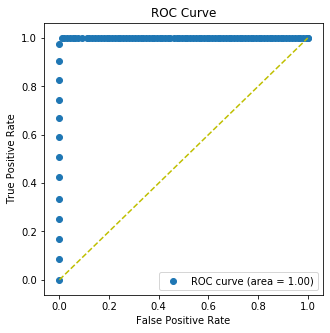

In [33]:
# your code here
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

ft_df = fitted_cv1.bestModel.stages[0].summary.roc

plt.figure(figsize=(5,5))
plt.scatter(ft_df.select('FPR').collect(),
         ft_df.select('TPR').collect(), label='ROC curve (area = %0.2f)'% roc)
plt.plot([0, 1], [0, 1], 'y--')
#plt.xlim([-0.01, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Grading Feedback

# Question 8
Create a new cross validator object named cv2 similar to cv1 but this time add a ParamGridBuilder.  Define a grid of elastic net regularization parameters. Fit cv2 and name the resulting fitted cross validator fitted_cv2.  The number of parameters in your grid should be limited such that it runs in a reasonable amount of time (around 5 to 10 minutes max).  

In [34]:
# your code here
grid = ParamGridBuilder().addGrid(logistic.regParam, [0.01, 0.5,2.0]).addGrid(logistic.elasticNetParam, [0.0, 0.5, 0.1]).build()
evaluator = BinaryClassificationEvaluator(labelCol='spam', metricName='areaUnderROC')
cv2 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid,numFolds=3,evaluator=evaluator,seed=70)
fitted_cv2 = cv2.fit(spam_df3)


### Grading feedback

# Question 9
- Print the resulting AUC from fitted_cv2. 
- Print the best model's L1 and L2 regularization parameters
- Analyze the L1 feature selection:
    - Print the total number of features
    - Print the number of features that L1 regularization eliminated
    - If any features were eliminated, print a sample of 10 words that were eliminated

In [35]:
# your code here
roc2 = evaluator.evaluate(fitted_cv2.transform(spam_df3))
print(f"1. Area under ROC Curve:{roc2}")

bestPipe = fitted_cv2.bestModel
bestLRModel = bestPipe.stages[0]
bestParams = bestLRModel.extractParamMap()
bestParams
print("2. Regularization parameter: ", bestParams[bestLRModel.getParam("regParam")])
print("3. Elastic net regularization parameter: ", bestParams[bestLRModel.getParam("elasticNetParam")])

voc1 = p_transformer.stages[0].vocabulary
print("4. Total number of features: ", len(voc1))

weights = fitted_cv2.bestModel.stages[0].coefficients.toArray()
print("5. Number of features that L1 regularization eliminated: ", len(weights[weights == 0]))
w = list(weights)
p = {}
for i in range(len(w)):
    p[voc1[i]] = fabs(w[i])
    
e_words = []
for item  in p.items():
    if item[1] == 0:
        e_words.append(item[0])
print("6. 10 Words eliminated by L1: ", e_words[0:10])

1. Area under ROC Curve:1.0
2. Regularization parameter:  0.5
3. Elastic net regularization parameter:  0.0
4. Total number of features:  13361
5. Number of features that L1 regularization eliminated:  167
6. 10 Words eliminated by L1:  ['wer', 'girl??', '"storming', 'phne,', '"height', 'grahmbell', 'girl..!', 'telphone...', 'invnted', '"short']


### Grading Feedback
-3 Multiple problems
- We were looking for AUC from the cross validation but would have accpted AUC from test data too.  You used training data which is probably why the accuracy is 100%.<br>
- We were looking for the actual L1/L2 multipliers not alpha and lambda

# Question 10
Analyze the best model weights in fitted_cv2.  Print the 10 words that contribute the most to predicting spam.  Print the 10 words that contribute the least to predicting spam.  Do the words make sense?  Explain.

In [36]:
# your code here
most_words = sorted(p.items(), key=lambda x: x[1], reverse=True)[0:10]
least_words = sorted(p.items(), key=lambda x: x[1], reverse=False)[0:10]

print("Words that contribute the most:\n")
for i in range(10):
    print(f"{i + 1}. Word:{most_words[i][0]},  Weight:{most_words[i][1]}")


print("\nWords that contribute the least:\n")
for i in range(10):
    print(f"{i + 1}. Word:{least_words[i][0]},  Weight:{least_words[i][1]}")    
    


Words that contribute the most:

1. Word:07090201529,  Weight:0.20788513001455278
2. Word:sexy?,  Weight:0.18330060607843854
3. Word:£12,  Weight:0.17754713185425383
4. Word:0207-083-6089,  Weight:0.17746146392909284
5. Word:08714712388,  Weight:0.17269768305895794
6. Word:stories,  Weight:0.17026475676389002
7. Word:08718738034.,  Weight:0.17019762679882186
8. Word:08712400200.,  Weight:0.17019762679882186
9. Word:08715205273,  Weight:0.17019762679882186
10. Word:gbp/sms,  Weight:0.16687348522733023

Words that contribute the least:

1. Word:wer,  Weight:0.0
2. Word:girl??,  Weight:0.0
3. Word:"storming,  Weight:0.0
4. Word:phne,,  Weight:0.0
5. Word:"height,  Weight:0.0
6. Word:grahmbell,  Weight:0.0
7. Word:girl..!,  Weight:0.0
8. Word:telphone...,  Weight:0.0
9. Word:invnted,  Weight:0.0
10. Word:"short,  Weight:0.0


Your comments here: The words that have 0.0 weights associated contribute the least. The Word:07090201529 has the highest weight hence contributes the most in predicting spam.

### Grading Feedback
Your words don't look correct.  I'm wondering if it is because you didn't remove stop words.

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a pyton call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically similar the equation below.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [37]:
# do not delete or change this cell
import pyspark.sql.functions as fn
# if running on data bricks
if is_databricks():
    # install sympy
    dbutils.library.installPyPI
    dbutils.library.installPyPI('sympy')
    print(dbutils.library.list())

In [38]:
# your code here
import sympy as sp
from sympy import Eq, solve
c, g, h, a, b, d, e, f = sp.symbols('c g h a b d e f')
equat = ((((c*g) - (c*h) + (e*((a + 1)**b))))-((d*(((a + 1)**b) - 1))/a)+((f*(((a + 1)**b) - 1))/a))
equation = Eq(equat)
s=solve(equation, c)
print(sp.latex(s))

\left[ \frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}\right]


Add your latex output here such that a human readable equation is displayed for grading:
$$\left[ \frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}\right]$$

### Grading Feedback
+5